<a href="https://colab.research.google.com/github/fmahboub/CAN_Political_Party_Emails_NER/blob/main/Canadian_Party_Emails_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# IMPORT LIBRARIES
!pip install transformers
import mailbox
import glob, os, ast
from transformers import pipeline
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from matplotlib.ticker import MaxNLocator

# Name Extraction

In [7]:
# DEFINE FUNCTIONS TO EXTRACT EMAIL BODIES, DATES AND OUT-PARTIES FROM .MBOX FILES

# FUNCTION TO CONVERT DATETIME TO DATE ELEMENT
# https://gist.github.com/kajdreef/afd7dfa68a2d19bf776ac8abbba61a0b

timeformat = '%a, %d %b %Y %H:%M:%S %z'
timeformatGMT = '%a, %d %b %Y %H:%M:%S %z (%Z)'

def getDate(timeString):
    if isTimeFormat(timeString, timeformat):
        dt = datetime.datetime.strptime(timeString, timeformat)
        return dt.date().isoformat()

    elif isTimeFormat(timeString, timeformatGMT):
        dt = datetime.datetime.strptime(timeString, timeformatGMT)
        return dt.date().isoformat()

    else:
        print(timeString)
        raise

def isTimeFormat(input, format):
    try:
        datetime.datetime.strptime(input, format)
        return True
    except ValueError:
        print(input)

# Functions to extract email body from .mbox file
# https://stackoverflow.com/questions/7166922/extracting-the-body-of-an-email-from-mbox-file-decoding-it-to-plain-text-regard
def getcharsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets

def handleerror(errmsg, emailmsg,cs):
    pass
    # print()
    # print(errmsg)
    # print("This error occurred while decoding with ",cs," charset.")
    # print("These charsets were found in the one email.",getcharsets(emailmsg))
    # print("This is the subject:",emailmsg['subject'])
    # print("This is the sender:",emailmsg['From'])

def getbodyfromemail(msg):
    body = None
    #Walk through the parts of the email to find the text body.    
    if msg.is_multipart():    
        for part in msg.walk():

            # If part is multipart, walk through the subparts.            
            if part.is_multipart(): 

                for subpart in part.walk():
                    if subpart.get_content_type() == 'text/plain':
                        # Get the subpart payload (i.e the message body)
                        body = subpart.get_payload(decode=True) 
                        #charset = subpart.get_charset()

            # Part isn't multipart so get the email body
            elif part.get_content_type() == 'text/plain':
                body = part.get_payload(decode=True)
                #charset = part.get_charset()

    # If this isn't a multi-part message then get the payload (i.e the message body)
    elif msg.get_content_type() == 'text/plain':
        body = msg.get_payload(decode=True) 

   # No checking done to match the charset with the correct part. 
    for charset in getcharsets(msg):
        try:
            body = body.decode(charset)
        except UnicodeDecodeError:
            handleerror("UnicodeDecodeError: encountered.",msg,charset)
        except AttributeError:
             handleerror("AttributeError: encountered" ,msg,charset)
    return body

In [8]:
# CREATE LIST OF ALL FILES WITH .MBOX FILETYPE
os.chdir('/content/drive/MyDrive/SEDNA Assessment/dataverse_files')
mbox_filenames = []
for file in glob.glob("*.mbox"):
    mbox_filenames.append(file)

# LOOP THROUGH EACH FILE AND EXTRACT THE DATE, BODY, & SENDING-PARTY OF EACH EMAIL USING ABOVE FUNCTIONS
email_dates, email_bodies, sending_parties = [], [], []
replace_dict = {'ï¿½':'é','\r\n\r\n':'\n','\t\t\r\n':'\n','\n \n \n \n':'\n',
                '\r\n':'\n','\n \n':'\n','\n\n':'\n'}
for filename in mbox_filenames:
  print(filename)
  sending_party = filename.split('-')[1]
  body_count = 0
  for num, email in enumerate(mailbox.mbox(filename)):
      if num!= 0 and num%100==0:
        print(num,'Emails Scanned...')
      body = getbodyfromemail(email)
      date = getDate(email['date'])
      if body != '' and body != None:
        try:
          email_dates.append(date)
          # try to replace indentations with spaces
          for key in replace_dict:
            try:
              # reduce reading space of emails for easier print() and correct for 'é'
              body = body.replace(key,replace_dict[key]).strip()
            except:
              pass
          email_bodies.append(body)
          sending_parties.append(sending_party)
          body_count+=1
        except:
          print('error occured')
          pass
  print(body_count,'Email Bodies Extracted...','\n')

# CHECK IF NUMBER OF EMAIL DATES MATCH NUMBER OF EMAIL BODIES
if len(email_dates)!=len(email_bodies):
    print('ERROR!')
else:
  print(len(email_bodies),'Email Bodies Extracted (TOTAL)')

PE-Conservatives-NoDonation-Subscription.mbox
100 Emails Scanned...
200 Emails Scanned...
300 Emails Scanned...
400 Emails Scanned...
500 Emails Scanned...
600 Emails Scanned...
700 Emails Scanned...
712 Email Bodies Extracted... 

PE-Conservatives-Donation-Subscription.mbox
100 Emails Scanned...
200 Emails Scanned...
300 Emails Scanned...
400 Emails Scanned...
500 Emails Scanned...
600 Emails Scanned...
654 Email Bodies Extracted... 

PE-Liberal-Donation-Subscription.mbox
100 Emails Scanned...
200 Emails Scanned...
300 Emails Scanned...
376 Email Bodies Extracted... 

PE-GreenParty-Donation-Subscription.mbox
100 Emails Scanned...
174 Email Bodies Extracted... 

PE-GreenParty-NoDonation-Subscription.mbox
100 Emails Scanned...
175 Email Bodies Extracted... 

PE-Liberal-NoDonation-Subscription.mbox
100 Emails Scanned...
200 Emails Scanned...
300 Emails Scanned...
400 Emails Scanned...
500 Emails Scanned...
600 Emails Scanned...
700 Emails Scanned...
800 Emails Scanned...
864 Email Bodies

In [ ]:
# CREATE DATAFRAME WITH 3 LISTS CREATED ABOVE
df = pd.DataFrame(list(zip(email_dates,email_bodies,sending_parties)), columns=['date','body','sending_party'])
df

,date,body,sending_party
0,2017-07-27,"Dear John,\nThe Liberals have a spending probl...",Conservatives
1,2017-07-27,"John —\nAccording to our records, your donatio...",Conservatives
2,2017-10-03,"Dear John,\nFor well over a month now, I have ...",Conservatives
3,2017-07-23,"Dear John,\nThe election is still over two yea...",Conservatives
4,2017-09-23,"Dear John,\nAs you know, Justin Trudeau’s Libe...",Conservatives
...,...,...,...
4705,2017-09-20,"Mike,\nDid you know that in Canada, bankrupt c...",NDP
4706,2015-08-23,Want to see more of this?\nFollow the tour on ...,NDP
4707,2014-11-13,"Mike,\nBefore going into politics, I was a tea...",NDP
4708,2017-03-31,"Hi Mike,\nFundraising deadlines like today's t...",NDP


In [ ]:
df['year'] = df['date'].apply(lambda x: x.split('-')[0])
df['week'] = df['date'].apply(lambda x: datetime.date(int(x.split('-')[0]),
                                        int(x.split('-')[1]),int(x.split('-')[2])).isocalendar()[1])
df['year_week'] = df['year']+'-'+df['week'].astype('str')
df

,date,body,sending_party,year,week,year_week
0,2017-07-27,"Dear John,\nThe Liberals have a spending probl...",Conservatives,2017,30,2017-30
1,2017-07-27,"John —\nAccording to our records, your donatio...",Conservatives,2017,30,2017-30
2,2017-10-03,"Dear John,\nFor well over a month now, I have ...",Conservatives,2017,40,2017-40
3,2017-07-23,"Dear John,\nThe election is still over two yea...",Conservatives,2017,29,2017-29
4,2017-09-23,"Dear John,\nAs you know, Justin Trudeau’s Libe...",Conservatives,2017,38,2017-38
...,...,...,...,...,...,...
4705,2017-09-20,"Mike,\nDid you know that in Canada, bankrupt c...",NDP,2017,38,2017-38
4706,2015-08-23,Want to see more of this?\nFollow the tour on ...,NDP,2015,34,2015-34
4707,2014-11-13,"Mike,\nBefore going into politics, I was a tea...",NDP,2014,46,2014-46
4708,2017-03-31,"Hi Mike,\nFundraising deadlines like today's t...",NDP,2017,13,2017-13


In [ ]:
# DEFINE FUNCTION WHICH WILL PULL NAMES FROM EMAIL BODIES

nlp = pipeline("ner")

def pull_names(text):
  global counter
  global names_list
  counter +=1
  old = text
  # print(old)

  ner_list_old = nlp(old)

  # COMBINE TOKENS WHICH MAY MAKE UP A SINGLE NAME
  names_old = []
  last_index = -10
  for ent in ner_list_old:
    if ent['entity'] == 'I-PER' or ent['entity'] == 'B-PER':
      if '##' in ent['word']:
        try:
          names_old[-1] = names_old[-1]+ent['word'].replace('##','')
        except:
          names_old.append(ent['word'].replace('##',''))
      elif last_index == (ent['index']-1):
        names_old[-1] = names_old[-1]+' '+ent['word']
      else:
        names_old.append(ent['word'])
      last_index = ent['index']

  names_final = names_old
  if counter%5==0:
    print(counter,'names extracted...')
  return names_final

# pull_names(email_bodies[150])

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english)


In [ ]:
# RUN PULL_NAMES FUNCTION ON EACH EMAIL IN DF AND SAVE AS CSV TO DISK
counter = 0
df['names'] = df['body'].apply(lambda x: pull_names(x))
df.to_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names.csv', index = False)
df

5 names extracted...
10 names extracted...
15 names extracted...
20 names extracted...
25 names extracted...
30 names extracted...
35 names extracted...
40 names extracted...
45 names extracted...
50 names extracted...
55 names extracted...
60 names extracted...
65 names extracted...
70 names extracted...
75 names extracted...
80 names extracted...
85 names extracted...
90 names extracted...
95 names extracted...
100 names extracted...
105 names extracted...
110 names extracted...
115 names extracted...
120 names extracted...
125 names extracted...
130 names extracted...
135 names extracted...
140 names extracted...
145 names extracted...
150 names extracted...
155 names extracted...
160 names extracted...
165 names extracted...
170 names extracted...
175 names extracted...
180 names extracted...
185 names extracted...
190 names extracted...
195 names extracted...
200 names extracted...
205 names extracted...
210 names extracted...
215 names extracted...
220 names extracted...
225 name

,date,body,sending_party,year,week,year_week,names
0,2017-07-27,"Dear John,\nThe Liberals have a spending probl...",Conservatives,2017,30,2017-30,"[John, Trudeau, Justin Trudeau, Andrew Schee]"
1,2017-07-27,"John —\nAccording to our records, your donatio...",Conservatives,2017,30,2017-30,"[John, Justin Trudeau]"
2,2017-10-03,"Dear John,\nFor well over a month now, I have ...",Conservatives,2017,40,2017-40,"[John, Justin Trudeau, Trudeau, Trudeau]"
3,2017-07-23,"Dear John,\nThe election is still over two yea...",Conservatives,2017,29,2017-29,"[John, Andrew Schee]"
4,2017-09-23,"Dear John,\nAs you know, Justin Trudeau’s Libe...",Conservatives,2017,38,2017-38,"[John, Justin Trudeau, Andrew Schee]"
...,...,...,...,...,...,...,...
4705,2017-09-20,"Mike,\nDid you know that in Canada, bankrupt c...",NDP,2017,38,2017-38,"[Mike, Justin Trudeau, Justin Trudeau, Robert ..."
4706,2015-08-23,Want to see more of this?\nFollow the tour on ...,NDP,2015,34,2015-34,"[Tom, Thomas, Tom, Thomas]"
4707,2014-11-13,"Mike,\nBefore going into politics, I was a tea...",NDP,2014,46,2014-46,"[Mike, Tom Mulcair, Mulcair, Tom, Jinny Jinny ..."
4708,2017-03-31,"Hi Mike,\nFundraising deadlines like today's t...",NDP,2017,13,2017-13,"[Mike, Mike, Tom Tom Mulir]"


In [84]:
# CLEAN UP INCORRECT NAMES

def clean_names(name_list):
  global counter
  counter+=1
  names_final = ast.literal_eval(name_list)
  # Check for sign off name repetition (i.e Rick Rick Devereux)
  names_final = [' '.join(name_sec for name_sec in list(dict.fromkeys(name.split(' ')).keys())) if len(set(name.split(' '))) < len(name.split(' ')) else name for name in names_final]
  # Check for common mispelled names (from NER mistakes)
  names_final = ['Justin Trudeau' if name=='Justin Trudeaueau' or name == 'Justinrudeau' or name == 'Justineau' \
                  or name =='Justin Trudeaumar' or name == 'Justin Trudeaueaueau' or name == 'Justin Trudeaurudeaueau' \
                  or name == 'Justinrudeaurudeaurudeau' else name for name in names_final]
  names_final = ['Trudeau' if name=='Trudeaueau' or name =='TRU' or name == 'Trudeaurudeau' or name=='eau' else name for name in names_final]
  names_final = ['Andrew Scheer' if name=='Andrew Schee' or name == 'Andrew Sc' else name for name in names_final]
  names_final = ['Thomas Mulcair' if name=='Thomas Mulir' or name == 'Tom Mulir' or name == 'TomM' or name == 'ThomasM' or name == 'Tom Mulcair' or name == 'Tom Mulca' else name for name in names_final]
  names_final = ['Elizabeth' if name=='ELIAB' or name=='ELIABH' else name for name in names_final]
  # Remove names with fewer than 2 letters and a couple particular cases with 2
  names_final = [name for name in names_final if len(name) >= 2 and name != 'MI' and name!= 'FA' and name != '"']
  # Check for hyphens with spaces
  names_final = [name.replace('–','').strip().replace('—','').strip() if '– ' in name or ' –' in name or ' – ' in name or '— ' in name or ' —' in name or ' — ' in name else name for name in names_final]
  if counter%100==0:
    print(counter,'names cleaned...')
  return names_final

counter = 0
df = pd.read_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names.csv')
df['names'] = df['names'].apply(lambda x: clean_names(x))
df.to_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names_clean.csv', index = False)


100 names cleaned...
200 names cleaned...
300 names cleaned...
400 names cleaned...
500 names cleaned...
600 names cleaned...
700 names cleaned...
800 names cleaned...
900 names cleaned...
1000 names cleaned...
1100 names cleaned...
1200 names cleaned...
1300 names cleaned...
1400 names cleaned...
1500 names cleaned...
1600 names cleaned...
1700 names cleaned...
1800 names cleaned...
1900 names cleaned...
2000 names cleaned...
2100 names cleaned...
2200 names cleaned...
2300 names cleaned...
2400 names cleaned...
2500 names cleaned...
2600 names cleaned...
2700 names cleaned...
2800 names cleaned...
2900 names cleaned...
3000 names cleaned...
3100 names cleaned...
3200 names cleaned...
3300 names cleaned...
3400 names cleaned...
3500 names cleaned...
3600 names cleaned...
3700 names cleaned...
3800 names cleaned...
3900 names cleaned...
4000 names cleaned...
4100 names cleaned...
4200 names cleaned...
4300 names cleaned...
4400 names cleaned...
4500 names cleaned...
4600 names cleaned.

In [85]:
# df = pd.read_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names_clean.csv')
# df2 = pd.read_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names.csv')
# for num,name in enumerate(df['names']):
#   # print(df2['body'][num])
#   print(df2['names'][num])
#   print(name,'\n')
#   if num>4528:
#     break

# Analysis

In [86]:
df = pd.read_csv('/content/drive/MyDrive/SEDNA Assessment/df_with_names_clean.csv')
df

,date,body,sending_party,year,week,year_week,names
0,2017-07-27,"Dear John,\nThe Liberals have a spending probl...",Conservatives,2017,30,2017-30,"['John', 'Trudeau', 'Justin Trudeau', 'Andrew ..."
1,2017-07-27,"John —\nAccording to our records, your donatio...",Conservatives,2017,30,2017-30,"['John', 'Justin Trudeau']"
2,2017-10-03,"Dear John,\nFor well over a month now, I have ...",Conservatives,2017,40,2017-40,"['John', 'Justin Trudeau', 'Trudeau', 'Trudeau']"
3,2017-07-23,"Dear John,\nThe election is still over two yea...",Conservatives,2017,29,2017-29,"['John', 'Andrew Scheer']"
4,2017-09-23,"Dear John,\nAs you know, Justin Trudeau’s Libe...",Conservatives,2017,38,2017-38,"['John', 'Justin Trudeau', 'Andrew Scheer']"
...,...,...,...,...,...,...,...
4705,2017-09-20,"Mike,\nDid you know that in Canada, bankrupt c...",NDP,2017,38,2017-38,"['Mike', 'Justin Trudeau', 'Justin Trudeau', '..."
4706,2015-08-23,Want to see more of this?\nFollow the tour on ...,NDP,2015,34,2015-34,"['Tom', 'Thomas', 'Tom', 'Thomas']"
4707,2014-11-13,"Mike,\nBefore going into politics, I was a tea...",NDP,2014,46,2014-46,"['Mike', 'Thomas Mulcair', 'Mulcair', 'Tom', '..."
4708,2017-03-31,"Hi Mike,\nFundraising deadlines like today's t...",NDP,2017,13,2017-13,"['Mike', 'Mike', 'Thomas Mulcair']"


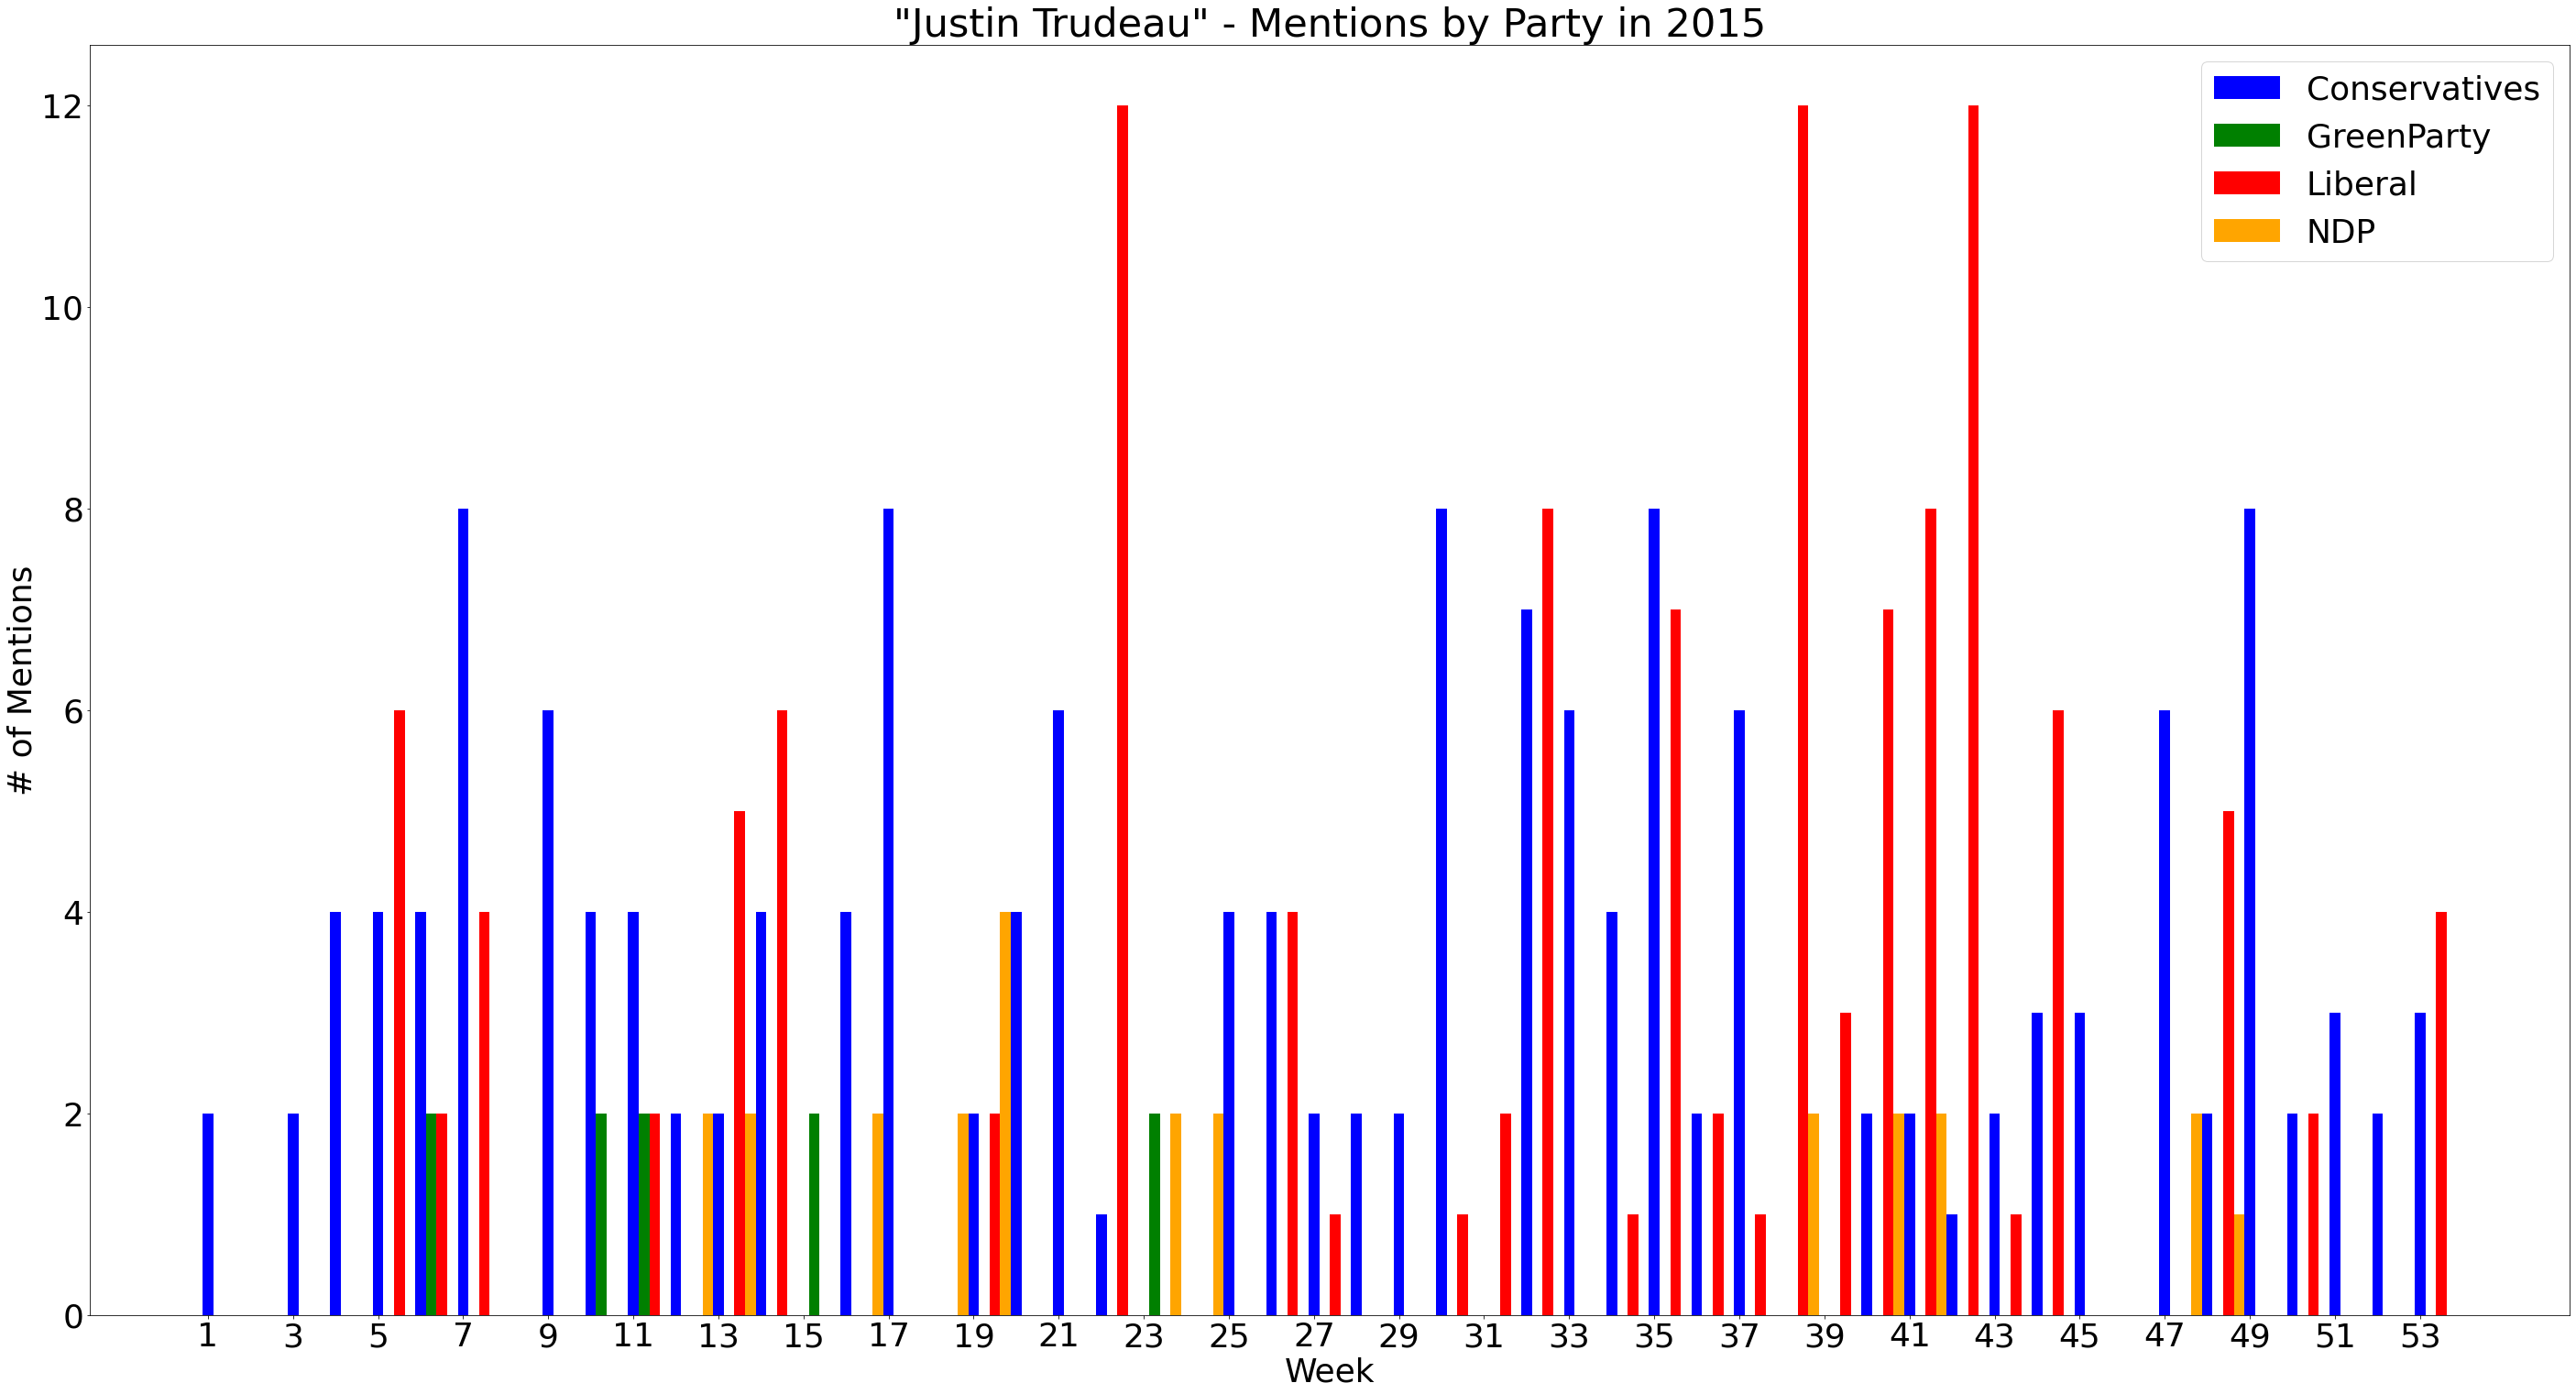

In [102]:
query = 'Justin Trudeau'
year = '2015' #options are 2014 - 2017
# *************************

def query_function(query,names):
  if query == '*':
    return 1
  elif query in ast.literal_eval(names):
    return 1
  else:
    return None

week_list = []
# Set y-axis to integers
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
colour_code = {'Conservatives':'b','GreenParty':'g','Liberal':'r','NDP':'orange'}
for num,party in enumerate(set(sending_parties)):
  # print(party)
  temp_df = df.copy().loc[df['sending_party']==party]
  temp_df[query] = temp_df['names'].apply(lambda x: query_function(query,x))
  temp_df = temp_df.loc[temp_df['year']==int(year)]
  temp_df = temp_df.drop(columns = ['date', 'body',	'sending_party', 'year', 'year_week', 'names']).groupby('week', as_index=False).count().sort_values(by='week')
  # display(temp_df)
  week_list+=temp_df['week'].to_list()
  week_list = list(set(week_list))
  globals()['x_'+party] = temp_df['week'].to_list()
  globals()['y_'+party] = temp_df[query].to_list()
  plt.bar([x + num/4 for x in globals()['x_'+party]], globals()['y_'+party], label = party, color=colour_code[party], width = 0.25)
  # break

plt.xlabel('Week')
# Set the y axis label of the current axis.
plt.ylabel('# of Mentions')
# Set a title of the current axes.
plt.title('"'+query+'"'+' - Mentions by Party in '+year)
# show a legend on the plot
plt.legend()
# Set figure size
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(48.5, 25.5)
# set font size
plt.rcParams.update({'font.size': 36})
# set xticks
plt.xticks(np.arange(1, max(week_list)+1, 2))
# show figure
plt.show()

In [92]:
for num,names in enumerate(df['names']):
  print(names,'\n')
  if num>20:
    break

['John', 'Trudeau', 'Justin Trudeau', 'Andrew Scheer'] 

['John', 'Justin Trudeau'] 

['John', 'Justin Trudeau', 'Trudeau', 'Trudeau'] 

['John', 'Andrew Scheer'] 

['John', 'Justin Trudeau', 'Andrew Scheer'] 

['Andrew'] 

['John', 'Andrew'] 

['John', 'Justin Trudeau', 'Trudeau', 'Justin Trudeau', 'Fidel Castro', 'Trudeau', 'Te', 'Trudeau', 'Justin Trudeau', 'Andrew Scheer', 'Justin Trudeau', 'John', 'Trudeau'] 

['John', 'Omar Khadr', 'Justin Trudeau', 'Christopher Speer', 'Justin Trudeau', 'Justin Trudeau', 'Justin Trudeau', 'Speer', 'Khadr', 'Omar Khadr', 'Sergeant Speer', 'Justin Trudeau', 'Khadr', 'Khadr', 'Khadr', 'Justin Trudeau', 'Andrew'] 

['John', 'Trudeau', 'Bill Morneau', 'Justin Trudeau', 'Trudeau', 'Justin Trudeau', 'Andrew Scheer'] 

['John'] 

['John', 'Trudeau', 'Trudeau', 'Justin Trudeau', 'Cory Hann'] 

['John', 'Michelle Rempel', 'Justin Trudeau', 'Trudeau'] 

['John', 'Andrew'] 

['John', 'Justin Trudeau', 'Justin Trudeau', 'Justin Trudeau', 'Justin Trudeau', 'J

In [95]:
index = 22
print(df['body'][index])
print(df['names'][index])

Dear John,
Keeping Canadians safe. Fostering an environment for a strong, stable economy.
Those should be considered top priorities for any government.
As Minister of State for Finance, I was proud to work alongside the Hon. Jim Flaherty and the Hon. Joe Oliver.
During that time together we accomplished many things. Major credit rating agencies consistently affirmed Canada’s AAA credit rating. There was recognition for our “track record of prudent fiscal management.”
Under our Conservative government:
Canada’s banking system was ranked the worlds soundest for seven years in a row.  Following the recession our GDP rose above pre-recession levels. The best performance in the G-7.  We recouped all our lost economic output and created more jobs than were lost during the recession.  On Bloomberg’s list of most attractive destinations to do business, Canada ranked 2nd, beating out every other G-20 nation.
At a time when the global economy remained uncertain, Canada was an island of stability